Best neighborhood will be determined by a weighted average of values taked from each of the datasets. The count of fires per neighborhood will be given the greatest weights, followed by daily traffic, and finally the number of steps. These counts will also be normalized to account for certain statistics being associated with larger counts without neccessarily being the most important, such as average daily traffic having far greater sums than the fire incidents. The final counts will be used to find the safest, and therefore best, neighborhood. 

Run All then interact with the last cell for the weighted output if ipywidgets does not then weights can be adjusted at the top of the cell

In [10]:
!pip install --upgrade geopandas

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: geopandas in /home/jupyter-ltm21/.local/lib/python3.8/site-packages (0.13.2)


First some general imports needed for all of the analysis. 

In [11]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets

First, we are going to import the information from the fire analysis in Liam Baird's notebook. Ridgemont here is considered to be the best neihgborhood using a score determined by the amount of fire incidents reported in the neihborhood and weighted by the type of incident. 

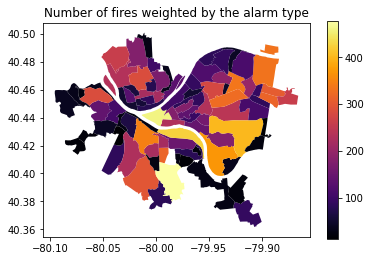

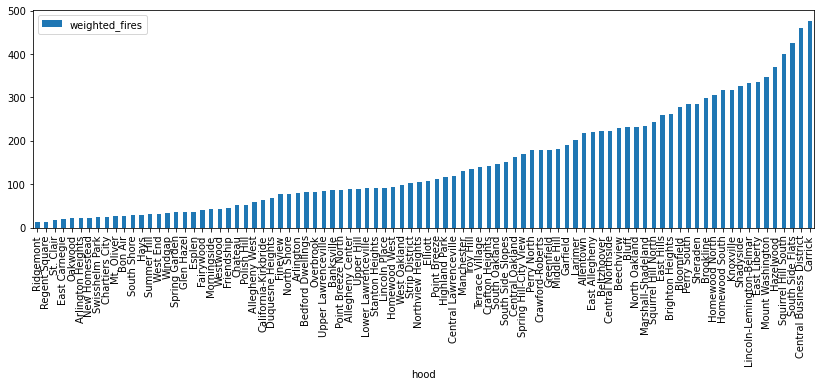

In [12]:
fires=pd.read_csv(r"fires/fireincidents.csv")
fires=fires[pd.isna(fires['neighborhood'])==False]
fires['neighborhood'].replace("Mount Oliver Borough","Mt. Oliver",inplace=True)
neighborhoods=gpd.read_file(r"neighborhoods/Neighborhoods_.shp")
weighted_fires=pd.DataFrame({'hood':fires['neighborhood'].unique()})
weighted_fires['weighted_fires'] = weighted_fires['hood'].apply(
    lambda nb:sum( fires[fires['neighborhood']==nb]["alarms"]+1)
)
fire_map = neighborhoods.merge(weighted_fires)
fire_map.plot(
    column='weighted_fires', legend=True,cmap="inferno",missing_kwds={"color": "tgrey"})
plt.title("Number of fires weighted by the alarm type");
weighted_fires.sort_values("weighted_fires").plot(kind='bar',x='hood',figsize=(14,4));

We are not brining in the traffic data from Liam Munley's notebook. South Side Flats is considered the best neighborhood here as determined by finding the neighborhood with the lowest average daily car traffic. 

{'Polish Hill': 15894.0, 'Squirrel Hill South': 79302.0, 'Central Northside': 5945.0, 'Bluff': 5365.0, 'Crafton Heights': 11500.0, 'Shadyside': 66132.0, 'Highland Park': 23471.0, 'North Shore': 10350.0, 'East Liberty': 51247.0, 'Mount Washington': 47336.0, 'Brookline': 39144.0, 'Squirrel Hill North': 35452.0, 'Bloomfield': 43101.0, 'Larimer': 37713.0, 'Friendship': 4887.0, 'Point Breeze': 31242.0, 'Regent Square': 16729.0, 'Central Lawrenceville': 13499.0, 'Knoxville': 7646.0, 'Central Oakland': 11306.0, 'Strip District': 29075.0, 'Greenfield': 7158.0, 'Windgap': 3062.0, 'Beechview': 4255.0, 'Upper Hill': 2860.0, 'Stanton Heights': 16272.0, 'Manchester': 21293.0, 'South Side Slopes': 26447.0, 'Perry North': 19114.0, 'North Oakland': 23821.0, 'East Hills': 16253.0, 'Duquesne Heights': 5831.0, 'Sheraden': 8532.0, 'Morningside': 14345.0, 'Central Business District': 2305.0, 'St. Clair': 2436.0, 'Perry South': 12075.0, 'Elliott': 4028.0, 'Carrick': 13787.0, 'Westwood': 15400.0, 'Allegheny 

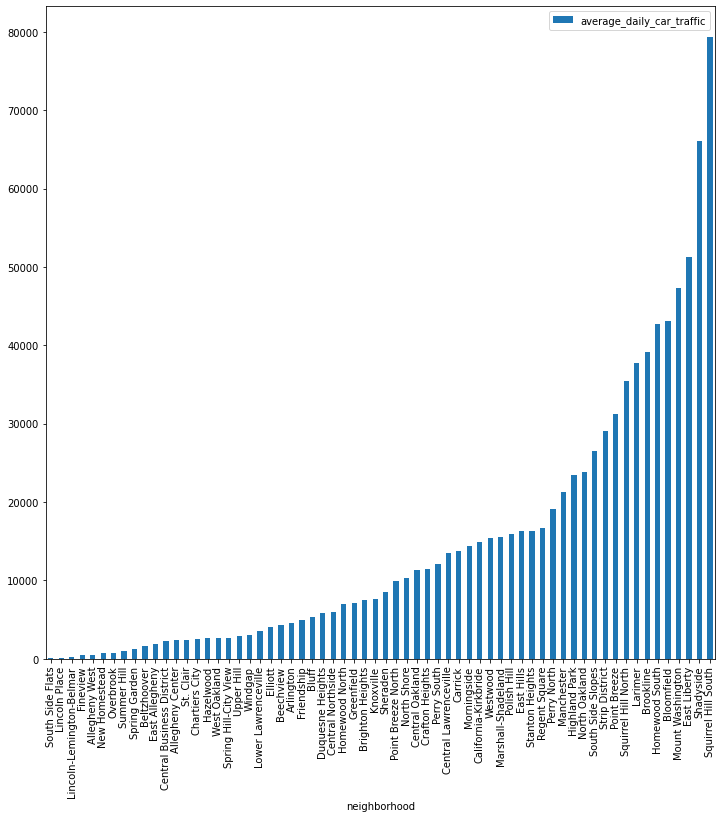

In [13]:

trafRaw = pd.read_csv("PittTraffic.csv")
trafRaw.head()
traf = trafRaw[trafRaw['average_daily_car_traffic'].notna()]

neighborhoods = dict()
i = 0
for name in traf.iloc[:, 18]:
    if name not in neighborhoods:
        if traf.iat[i, 6]!= 0:
            neighborhoods[name] = traf.iat[i, 6]
            #print("here\n")
        else: 
            neighborhoods[name] = 0
            #print("or here\n")
    else:
        if traf.iat[i, 6]!= 0:
            neighborhoods[name] += traf.iat[i, 6]
            #print("or maybe\n")
        else:
            neighborhoods[name] += 0
            #print("pls here\n")
    i += 1
print(neighborhoods)

num_cars = traf.groupby("neighborhood").sum()['average_daily_car_traffic']
num_cars = pd.DataFrame(num_cars)
num_cars = num_cars.sort_values('average_daily_car_traffic', ascending=True)
num_cars.plot.bar(figsize=(12,12))

Now, the information on the amount of steps in each neighborhood is brought in from the work done in Charles Marianik's notebook. This has Mount Oliver Borough, Strip District, Chartiers City, Glen Hazel, Larimer, Bluff, Manchester, and East Liberty all as the best neighborhood as they are all tied with the lowest amount of stairways at 1. 

{'Mount Oliver Borough': 1, 'Strip District': 1, 'Chartiers City': 1, 'Glen Hazel': 1, 'Larimer': 1, 'Bluff': 1, 'Manchester': 1, 'East Liberty': 1, 'Bon Air': 2, 'St. Clair': 2, 'Windgap': 2, 'East Carnegie': 2, 'Shadyside': 2, 'South Shore': 2, 'Point Breeze North': 2, 'Central Northside': 3, 'Ridgemont': 3, 'Esplen': 3, 'North Shore': 3, 'Allegheny West': 3, 'North Oakland': 4, 'East Allegheny': 4, 'Crawford-Roberts': 4, 'Regent Square': 4, 'Central Oakland': 5, 'West End': 5, 'Terrace Village': 5, 'Oakwood': 5, 'Bedford Dwellings': 6, 'West Oakland': 6, 'Allegheny Center': 6, 'Banksville': 7, 'Morningside': 7, 'Squirrel Hill North': 7, 'Mt. Oliver': 7, 'Bloomfield': 7, 'Lincoln Place': 7, 'Central Business District': 7, 'Knoxville': 8, 'Point Breeze': 8, 'South Side Flats': 8, 'California-Kirkbride': 9, 'Homewood North': 9, 'Crafton Heights': 9, 'East Hills': 9, 'Central Lawrenceville': 9, 'South Oakland': 10, 'Middle Hill': 11, 'Upper Lawrenceville': 12, 'Lincoln-Lemington-Belmar'

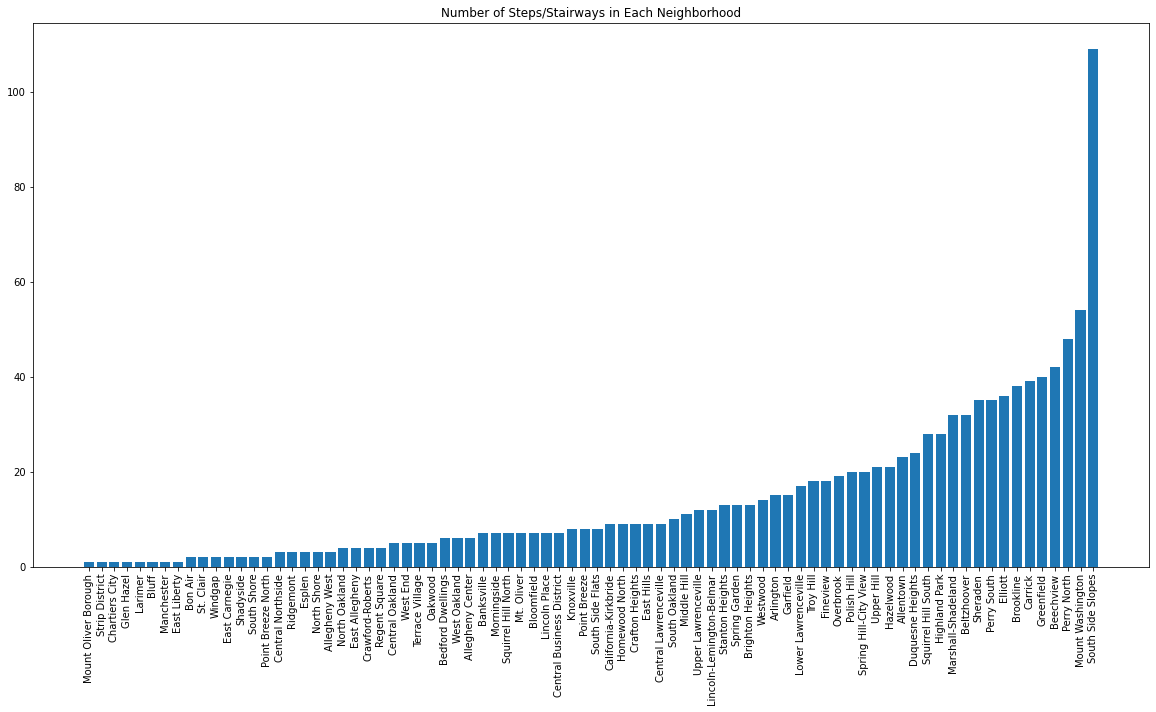

In [14]:
steps = pd.read_csv("steps.csv", index_col="neighborhood", parse_dates=True)

neighborhoods = dict()

for name in steps.index:
    if name not in neighborhoods:
        neighborhoods[name] = 1
    else:
        neighborhoods[name] += 1

sorted_neighborhoods = dict(sorted(neighborhoods.items(), key=lambda item: item[1]))

print(sorted_neighborhoods)

fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(sorted_neighborhoods.keys(), sorted_neighborhoods.values())
ax.set_title("Number of Steps/Stairways in Each Neighborhood")
plt.xticks(rotation=90)
plt.show()

In the following code, we are assigning the information from each of the preliminary observations to a map of Pittsburgh. This allows us to have a heat map to visiualy identify where the best and worst neighborhoods are within Pittsburgh.  

In [15]:
combined=pd.merge(pd.merge(fire_map,
            pd.Series(sorted_neighborhoods).to_frame().reset_index().rename(columns={'index':'hood',0:'steps'})),num_cars.reset_index().rename(columns={'neighborhood':'hood'}))

Text(0.5, 1.0, 'Number of Steps/Stairways')

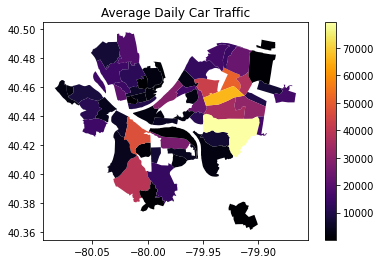

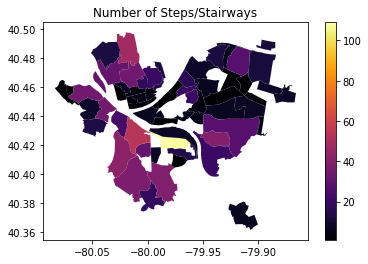

In [16]:

combined.plot(column='average_daily_car_traffic', legend=True,cmap="inferno",missing_kwds={"color": "tgrey"})
plt.title("Average Daily Car Traffic")
combined.plot(column='steps', legend=True,cmap="inferno",missing_kwds={"color": "tgrey"})
plt.title("Number of Steps/Stairways")

Here we are going to convert all of the information that we have gathered so far into our final analysis. We will first normalize the values by dividing each neighborhood's value in each category (fires, traffic, and stairways) by the total count across all neighborhoods in that category. This allows us to compare the scores for each category more directly across neighborhoods without worrying about high volume statistics overshadowing the smaller volume ones. 

These normalized values are also then weighted so that the more important statistics when trying to determine the safety of the neighborhood are more impactful in determining the safety score of the neighborhood. The highest weighted statistic will be fire incidents, followed by daily average car traffic, and finally the number of stairways. 

We weight them in this way beacause we believe that the amount of fires in a neighborhood is of critical importance when determining how safe a neighborhood is as rampant fires post an immediate and direct risk to an individual living there. Car traffic, while important in determining the general safety of the streets as well as health risks from car pollutants, was not quite as important are fire incidents. Finally, the number of stairways can be potentially unsafe for individuals with limited mobility, however they are mostly safe for the majority of individuals and have therefore been given the lowest weight. 

In [17]:
from IPython.display import clear_output, display
import numpy as np
df=combined.dropna(subset=['steps','average_daily_car_traffic','weighted_fires'])
def minimax(col):
    return (col-col.min())/(col.max()-col.min())
def z_score(col):
    return (col-col.mean())/col.std()
def identity(col):
    return col
def log(col):
    return col.apply(lambda x: np.log(x+1))
df.set_index('hood',inplace=True)
df.rename(columns={'average_daily_car_traffic':'Average Daily Car Traffic','steps':'Number of Steps','weighted_fires':'Response Weighted Fires'},inplace=True)
for metric in ['Average Daily Car Traffic','Number of Steps','Response Weighted Fires']:
    for scaling in [minimax,z_score,identity,log]:
        df[f'{scaling.__name__} {metric}']=scaling(df[metric])


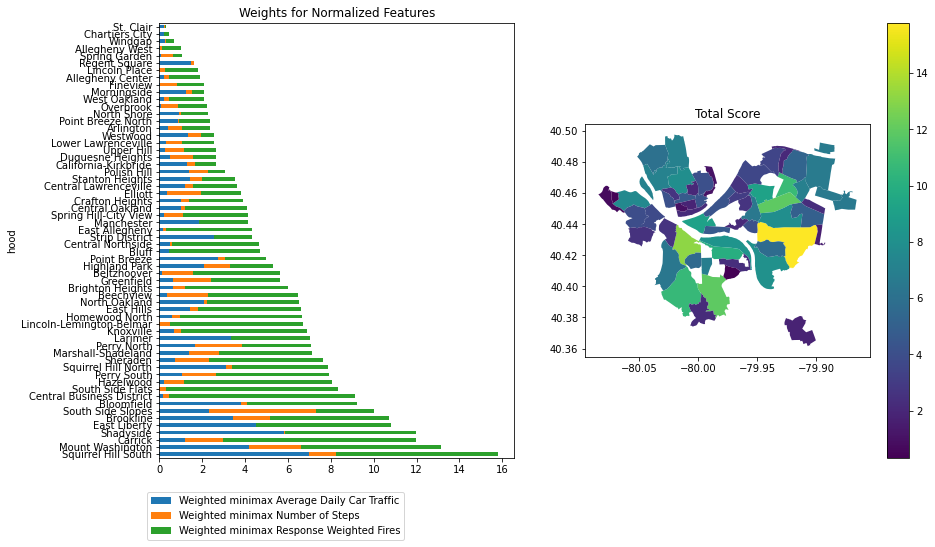

In [18]:
#starting weights here
car_weight=7
steps_weight=5
fire_weight=9
def plot_weights(car_weight,steps_weight,fire_weight,sort_score=False,normalization="minimax"):
    clear_output(wait=True)
    global df    
    metrics=['Average Daily Car Traffic','Number of Steps','Response Weighted Fires']
    weights=car_weight,steps_weight,fire_weight
    for metric,weight in zip(metrics,weights):
        df[f'Weighted {normalization} {metric}']=df[f'{normalization} {metric}']*weight
    df['score']=df[[f'Weighted {normalization} {metric}' for metric in metrics]].sum(axis=1)
    if sort_score:
        df=df.sort_values('score',ascending=False)
    else:
        df=df.sort_index()
    fig, (ax0,ax1) = plt.subplots(1,2)
    df[[f'Weighted {normalization} {metric}' for metric in metrics]].plot(kind='barh',figsize=(14,8),stacked=True,ax=ax0)
    ax0.set_title("Weights for Normalized Features")
    ax0.legend(loc='lower left', bbox_to_anchor=(-0.05,- 0.2))
    ax1.set_title("Total Score")
    df.plot(column='score', legend=True,missing_kwds={"color": "tgrey"},ax=ax1)
widgets.interact    (plot_weights,
                 car_weight=widgets.FloatSlider(min=0, max=10, step=0.01, value=car_weight),
                 steps_weight=widgets.FloatSlider(min=0, max=10, step=0.01, value=steps_weight),
                 fire_weight=widgets.FloatSlider(min=0, max=10, step=0.01, value=fire_weight),
                 sort_score=widgets.Checkbox(value=True),
                 normalization=widgets.Dropdown(options=["minimax","z_score","identity","log"],value="minimax")
                 );


In [19]:
df['score']

hood
Squirrel Hill South          15.775862
Mount Washington             13.125807
Carrick                      11.967841
Shadyside                    11.953211
East Liberty                 10.785071
Brookline                    10.691079
South Side Slopes            10.004429
Bloomfield                    9.217755
Central Business District     9.122232
South Side Flats              8.334850
Hazelwood                     8.068308
Perry South                   7.907180
Squirrel Hill North           7.882114
Sheraden                      7.613382
Marshall-Shadeland            7.102996
Perry North                   7.055837
Larimer                       7.008946
Knoxville                     6.866957
Lincoln-Lemington-Belmar      6.723228
Homewood North                6.645173
East Hills                    6.587891
North Oakland                 6.501702
Beechview                     6.453772
Brighton Heights              6.022877
Greenfield                    5.647973
Beltzhoover         

The best neighborhood using the weighted normalized values and taking into account fires, average daily traffic, and steps per neighborhood is St. Clair, with an overall score of 0.329. 

The following is the unnormalized form of these weighted counts, to represent another look a the data. 

Lincoln Place
Fineview
Allegheny West
Lincoln-Lemington-Belmar
South Side Flats
Overbrook
Spring Garden
Beltzhoover
East Allegheny
St. Clair


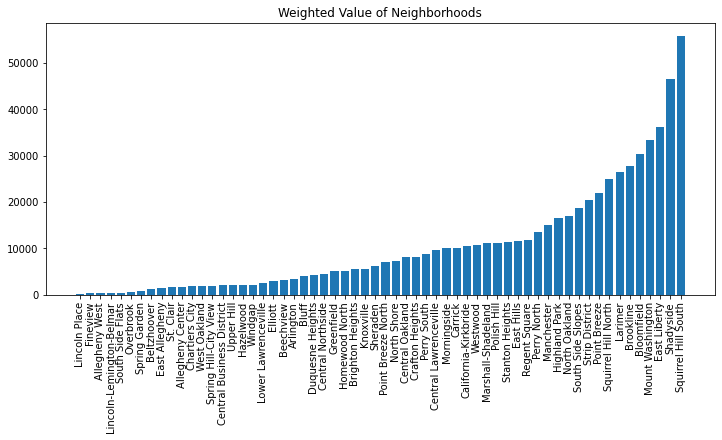

In [21]:
import pandas as pd
import numpy as np
import geopandas
%matplotlib inline
import matplotlib.pyplot as plt

# neighborhood column focus
steps = pd.read_csv("steps.csv", index_col="neighborhood", parse_dates=True)

# initialize dictionary
neighborhoods = dict()

# add up number of steps/stairways per neighborhood
for name in steps.index:
    if name not in neighborhoods:
        neighborhoods[name] = 1
    else:
        neighborhoods[name] += 1

# sorts the neighborhood based on item[1], the value/#steps in dict.
sorted_neighborhoods = dict(sorted(neighborhoods.items(), key=lambda item: item[1]))

fires=pd.read_csv(r"fires/fireincidents.csv")
fires=fires[pd.isna(fires['neighborhood'])==False]
fires['neighborhood'].replace("Mount Oliver Borough","Mt. Oliver",inplace=True)

neighborhoods=gpd.read_file(r"neighborhoods/Neighborhoods_.shp")
weighted_fires=pd.DataFrame({'hood':fires['neighborhood'].unique()})
weighted_fires['weighted_fires'] = weighted_fires['hood'].apply(
    lambda nb:sum( fires[fires['neighborhood']==nb]["alarms"]+1)
)

fireDict = weighted_fires.set_index('hood').T.to_dict('list')

trafRaw = pd.read_csv("PittTraffic.csv")
trafRaw.head()
traf = trafRaw[trafRaw['average_daily_car_traffic'].notna()]

neighborhoods = dict()
i = 0
for name in traf.iloc[:, 18]:
    if name not in neighborhoods:
        if traf.iat[i, 6]!= 0:
            neighborhoods[name] = traf.iat[i, 6]
            #print("here\n")
        else: 
            neighborhoods[name] = 0
            #print("or here\n")
    else:
        if traf.iat[i, 6]!= 0:
            neighborhoods[name] += traf.iat[i, 6]
            #print("or maybe\n")
        else:
            neighborhoods[name] += 0
            #print("pls here\n")
    i += 1

weighted = dict()
for x in neighborhoods:
    if x in sorted_neighborhoods:
        if x in fireDict:
            fireNum = 0.9*(fireDict.get(x)[0])
            stepNum = 0.5*(sorted_neighborhoods.get(x))
            trafNum = 0.7*(neighborhoods.get(x))
            weighted[x] = (stepNum + trafNum + fireNum)

sorted_weight = dict(sorted(weighted.items(), key=lambda item: item[1]))

count = 0
for name in sorted_weight:
    if count<10:
        print(name)
    count += 1

fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(sorted_weight.keys(), sorted_weight.values())
ax.set_title("Weighted Value of Neighborhoods")
plt.xticks(rotation=90)

plt.show()

We can see that while when the data is non-normalized, the best neighborhood would have been Lincoln Place, with the true best neighborhood, St. Clair, only appearing at number 10 on the list. This shows why the normalization of the values is important, as it ensures that the values with large counts don't overshadow the values with smaller counts that are more significant without needing to apply an extremely small weight to the large count statistics. 

Liam Munley - The non-normalized, but still weighted, data showed Lincoln Place to be the best neighborhood. This is what I expected to see after my own analysis of daily traffic as well in which it placed second, as well seeing it show up in the top best neighborhoods through my partner's analysis. However, upon the normalization of the data I was surprised to see that the data pointed to St. Clair being the best neighborhood. The fact that this neighborhood was so close to where I lived surprised me, but also made me happy to see that one of my favorite neighborhoods was also the best. I believe that the normalization of the data being what showed this proved that including the normalization was crtitical to establishing the best possible data set to reach our conclusion. 